#  Image Analysis

## Imports

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import bytescale, toimage
import sys
import os
#import gzip
#from PIL import Image as pilImage

from image import Image, show
#from utils import unpickle, reshape_cifar10_image, process_cifar10_image
from utils.utils import unpickle, reshape_cifar10_image, process_cifar10_image
from utils.utils import block_resampling, jackknife_err
from utils.count_bonds import count_bonds
from utils.block_images import block_image

%matplotlib inline

## Download CIFAR-10 dataset and extract into './cifar10_data/' directory

In [2]:
# download cifar-10-data and extract into './cifar10_data/' directory
! mkdir cifar10_data 
! curl -O https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
! tar -xvf cifar-10-python.tar.gz -C ./cifar10_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  3900k      0  0:00:42  0:00:42 --:--:-- 2420kM    0     0  3955k      0  0:00:42  0:00:18  0:00:24 3382kM    0     0  4195k      0  0:00:39  0:00:26  0:00:13 5285k  0     0  4143k      0  0:00:40  0:00:28  0:00:12 4105k3M    0     0  4135k      0  0:00:40  0:00:30  0:00:10 3556k
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


## Testing with CIFAR-10

### Define relevant directories, load first batch of data 

In [6]:
cifar10_data_prefix = './data/cifar10_data/cifar-10-batches-py/'
cifar10_data_batch1_file = cifar10_data_prefix + 'data_batch_1'
cifar10_data_batch2_file = cifar10_data_prefix + 'data_batch_2'
cifar10_data_batch3_file = cifar10_data_prefix + 'data_batch_3'
cifar10_data_batch4_file = cifar10_data_prefix + 'data_batch_4'
cifar10_data_batch5_file = cifar10_data_prefix + 'data_batch_5'

cifar10_batch1 = unpickle(cifar10_data_batch1_file)

In [7]:
cifar10_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

### Examples

(<matplotlib.figure.Figure at 0x1118e57b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1118e5f98>)

(<matplotlib.figure.Figure at 0x1118e58d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1118997f0>)

(<matplotlib.figure.Figure at 0x111846eb8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11208fc88>)

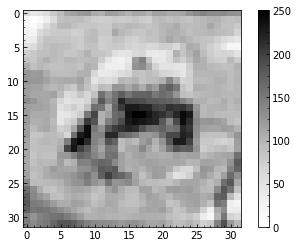

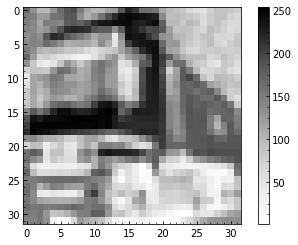

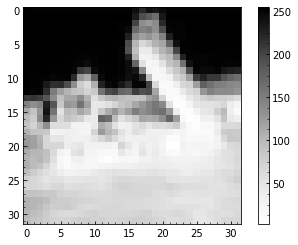

In [8]:
# extract first three images from dataset and plot, just for reference
image0 = process_cifar10_image(cifar10_batch1[b'data'][0])
image1 = process_cifar10_image(cifar10_batch1[b'data'][1])
image2 = process_cifar10_image(cifar10_batch1[b'data'][2])

show(image0)
show(image1)
show(image2)

In [ ]:
# extract B/W boundaries using cutoff = 0.5 and show resulting image
img0 = Image(image0)
boundary_img0 = img0.get_boundaries(0.5)
show(boundary_img0)

### Iteratively block sample image (example)

In [21]:
# iteratively block image:
#    (64, 64) --> (32, 32) --> (16,16) --> (8, 8) --> (4, 4)
blocked1_boundary_img0 = block_image(boundary_img0)
blocked2_boundary_img0 = block_image(blocked1_boundary_img0)
blocked3_boundary_img0 = block_image(blocked2_boundary_img0)
blocked4_boundary_img0 = block_image(blocked3_boundary_img0)

(<matplotlib.figure.Figure at 0x11109bcf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1167ddb38>)

(<matplotlib.figure.Figure at 0x11109b9e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1169414e0>)

(<matplotlib.figure.Figure at 0x1167b8710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11136b6d8>)

(<matplotlib.figure.Figure at 0x1168d08d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1166f70b8>)

(<matplotlib.figure.Figure at 0x116700d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1166b5be0>)

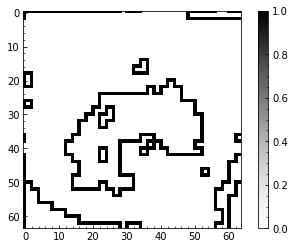

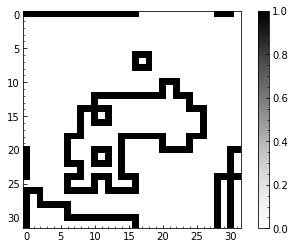

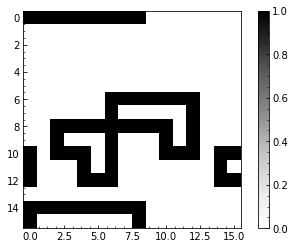

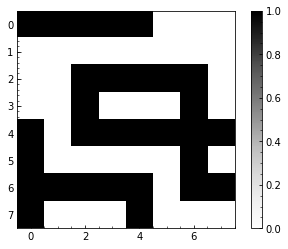

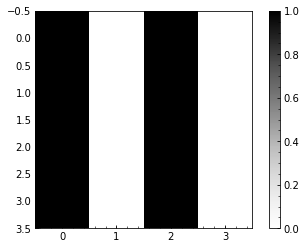

In [22]:
show(boundary_img0)
show(blocked1_boundary_img0.reshape((32,32)))
show(blocked2_boundary_img0.reshape((16,16)))
show(blocked3_boundary_img0.reshape((8,8)))
show(blocked4_boundary_img0.reshape((4,4)))

### Shuffle data and load images for analysis

In [45]:
# shuffle data
np.random.shuffle(cifar10_batch1[b'data'])
# select first num_sample_images from batch1 as sample data
num_sample_images = 50
cifar10_images0 = np.array([process_cifar10_image(img) for img in
                            cifar10_batch1[b'data'][:num_sample_images]])
cifar10_images1 = np.array([process_cifar10_image(img) for img in
                            cifar10_batch1[b'data'][num_sample_images:2*num_sample_images]])
cifar10_images2 = np.array([process_cifar10_image(img) for img in
                            cifar10_batch1[b'data'][2*num_sample_images:3*num_sample_images]])
print(cifar10_images0.shape)
print(cifar10_images1.shape)
print(cifar10_images2.shape)

(50, 32, 32)
(50, 32, 32)
(50, 32, 32)


### Define cutoffs and obtain boundary images

In [47]:
x = [0, 1, 2, 3]
y = [4, 5, 6, 7]
z = [8, 9, 10, 11]
xyz = zip(x, y, z)
print(xyz)

In [53]:
for (i, j, k) in zip(x,y,z):
    print(f"{i}, {j}, {k}")

0, 4, 8
1, 5, 9
2, 6, 10
3, 7, 11


In [54]:
# create array of cutoffs for converting image to black/white pixels
#cutoffs = np.arange(0.1, 1., 0.05)
cutoffs = [0.2, 0.3, 0.4]
cutoffs.extend(list(np.arange(0.4, 0.8, 0.02)))
cutoffs.extend(list(np.array([0.8, 0.9, 1.0])))

cifar10_boundary_images0 = []
cifar10_boundary_images1 = []
cifar10_boundary_images2 = []
for (image0, image1, image2) in zip(cifar10_images0, cifar10_images1, cifar10_images2):
    img0 = Image(image0)
    img1 = Image(image1)
    img2 = Image(image2)
    # for each image, try different cutoff values and append resulting image
    # to boundary_images array
    boundary_images0 = np.array([img0.get_boundaries(cutoff) 
                                for cutoff in cutoffs])
    boundary_images1 = np.array([img1.get_boundaries(cutoff) 
                                for cutoff in cutoffs])
    boundary_images2 = np.array([img2.get_boundaries(cutoff) 
                                for cutoff in cutoffs])
    # create array with the boundary_images obtained from each cutoff value
    # to cifar10_boundary_images array, with one image per row
    # i.e. cifar10_boundary_images will have shape:
    #    [num_images, num_cutoffs, 32, 32] 
    cifar10_boundary_images0.append(np.array(boundary_images0))
    cifar10_boundary_images1.append(np.array(boundary_images1))
    cifar10_boundary_images2.append(np.array(boundary_images2))
cifar10_boundary_images0 = np.array(cifar10_boundary_images0)
cifar10_boundary_images1 = np.array(cifar10_boundary_images1)
cifar10_boundary_images2 = np.array(cifar10_boundary_images2)
print(cifar10_boundary_images0.shape)
print(cifar10_boundary_images1.shape)
print(cifar10_boundary_images2.shape)

(50, 26, 64, 64)
(50, 26, 64, 64)
(50, 26, 64, 64)


### Block boundary images 

In [64]:
blocked_boundary_images0 = []
blocked_boundary_images1 = []
blocked_boundary_images2 = []
zip_bdy_images = zip(cifar10_boundary_images0, cifar10_boundary_images1,
                     cifar10_boundary_images2)
for (images0, images1, images2) in zip_bdy_images:
    boundary_images0 = []
    boundary_images1 = []
    boundary_images2 = []
    original_size = images[0].shape[0]
    new_size = original_size // 2
    zip_images = zip(images0, images1, images2)
    for (cutoff_image0, cutoff_image1, cutoff_image2) in zip_images:
        boundary_images0.append(block_image(cutoff_image0).reshape(new_size,
                                                                   new_size))
        boundary_images1.append(block_image(cutoff_image1).reshape(new_size,
                                                                   new_size))
        boundary_images2.append(block_image(cutoff_image2).reshape(new_size,
                                                                   new_size))
    blocked_boundary_images0.append(np.array(boundary_images0))
    blocked_boundary_images1.append(np.array(boundary_images1))
    blocked_boundary_images2.append(np.array(boundary_images2))
blocked_boundary_images0 = np.array(blocked_boundary_images0)
blocked_boundary_images1 = np.array(blocked_boundary_images1)
blocked_boundary_images2 = np.array(blocked_boundary_images2)
print(blocked_boundary_images0.shape)
print(blocked_boundary_images1.shape)
print(blocked_boundary_images2.shape)

(50, 26, 32, 32)
(50, 26, 32, 32)
(50, 26, 32, 32)


### Run bond counter on unblocked images ($\langle N_b\rangle$, $\langle \Delta_{N_b}^2\rangle$)

In [70]:
Nb_avg0 = []
delta_Nb0 = []
Nb_avg1 = []
delta_Nb1 = []
Nb_avg2 = []
delta_Nb2 = []
# swap first two axes so that each row corresponds 
# to a unique value of greyscale cutoff, across all images
cifar10_boundary_imagesT0 = np.transpose(cifar10_boundary_images0, (1, 0, 2, 3))
cifar10_boundary_imagesT1 = np.transpose(cifar10_boundary_images1, (1, 0, 2, 3))
cifar10_boundary_imagesT2 = np.transpose(cifar10_boundary_images2, (1, 0, 2, 3))
zip_bdy_imagesT = zip(cifar10_boundary_imagesT0, cifar10_boundary_imagesT1,
                      cifar10_boundary_imagesT2)
for (image_set0, image_set1, image_set2) in zip_bdy_imagesT:
    # iterate over rows, where each row contains different 'worm'-type 
    # images, all obtained with the same cutoff
    Nb_avg0_, delta_Nb0_ = count_bonds(image_set0) # run count_bonds on row
    Nb_avg1_, delta_Nb1_ = count_bonds(image_set1) # run count_bonds on row
    Nb_avg2_, delta_Nb2_ = count_bonds(image_set2) # run count_bonds on row
    Nb_avg0.append(Nb_avg0_)
    Nb_avg1.append(Nb_avg1_)
    Nb_avg2.append(Nb_avg2_)
    delta_Nb0.append(delta_Nb0_)
    delta_Nb1.append(delta_Nb1_)
    delta_Nb2.append(delta_Nb2_)
    #Nb_avg.extend([Nb_avg0_, Nb_avg1_, Nb_avg2_])
    #delta_Nb.extend([delta_Nb0_, delta_Nb1_, delta_Nb2_])
Nb_avg0 = np.array(Nb_avg0) / (32*32)
delta_Nb0 = np.array(delta_Nb0) / (32*32)
Nb_avg1 = np.array(Nb_avg1) / (32*32)
delta_Nb1 = np.array(delta_Nb1) / (32*32)
Nb_avg2 = np.array(Nb_avg2) / (32*32)
delta_Nb2 = np.array(delta_Nb2) / (32*32)

### Run bond counter on blocked images ($\langle N_b\rangle$, $\langle \Delta_{N_b}^2\rangle$)

In [72]:
Nb_avg_blocked0 = []
delta_Nb_blocked0 = []
Nb_avg_blocked1 = []
delta_Nb_blocked1 = []
Nb_avg_blocked2 = []
delta_Nb_blocked2 = []
# swap first two axes so that each row corresponds 
# to a unique value of greyscale cutoff, across all images
blocked_boundary_imagesT0 = np.transpose(blocked_boundary_images0, 
                                         (1, 0, 2, 3))
blocked_boundary_imagesT1 = np.transpose(blocked_boundary_images1, 
                                         (1, 0, 2, 3))
blocked_boundary_imagesT2 = np.transpose(blocked_boundary_images2, 
                                         (1, 0, 2, 3))
zip_blocked_bdy_imagesT = zip(blocked_boundary_imagesT0, 
                              blocked_boundary_imagesT1,
                              blocked_boundary_imagesT2)

for (image_set0, image_set1, image_set2) in zip_blocked_bdy_imagesT:
    # iterate over rows, where each row contains different 'worm'-type 
    # images, all obtained with the same cutoff
    Nb_avg0_, delta_Nb0_ = count_bonds(image_set0) # run count_bonds on row
    Nb_avg1_, delta_Nb1_ = count_bonds(image_set1) # run count_bonds on row
    Nb_avg2_, delta_Nb2_ = count_bonds(image_set2) # run count_bonds on row
    Nb_avg_blocked0.append(Nb_avg0_)
    Nb_avg_blocked1.append(Nb_avg1_)
    Nb_avg_blocked2.append(Nb_avg2_)
    delta_Nb_blocked0.append(delta_Nb0_)
    delta_Nb_blocked1.append(delta_Nb1_)
    delta_Nb_blocked2.append(delta_Nb2_)
    #Nb_avg_blocked.extend([Nb_avg0_, Nb_avg1_, Nb_avg2_])
    #delta_Nb_blocked.extend([delta_Nb0_, delta_Nb1_, delta_Nb2_])
Nb_avg_blocked0 = np.array(Nb_avg_blocked0) / (16*16)
delta_Nb_blocked0 = np.array(delta_Nb_blocked0) / (16*16)
Nb_avg_blocked1 = np.array(Nb_avg_blocked1) / (16*16)
delta_Nb_blocked1 = np.array(delta_Nb_blocked1) / (16*16)
Nb_avg_blocked2 = np.array(Nb_avg_blocked2) / (16*16)
delta_Nb_blocked2 = np.array(delta_Nb_blocked2) / (16*16)

## Plots

### Unblocked results

In [73]:
print(Nb_avg0.shape)
print(Nb_avg1.shape)
print(Nb_avg2.shape)

(26,)
(26,)
(26,)


Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle N_b\\rangle / V$')

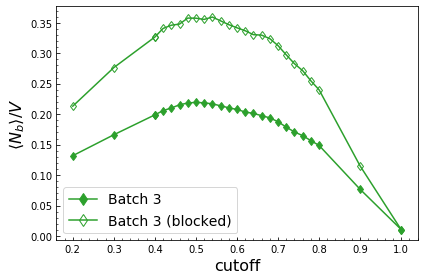

In [87]:
fig, ax = plt.subplots()
#ax.plot(cutoffs, Nb_avg0, marker='s', ls='-', label='Batch 1', color='C0')
#ax.plot(cutoffs, Nb_avg_blocked0, marker='s', ls='-', label='Batch 1 (blocked)', fillstyle='none', color='C0')
#ax.plot(cutoffs, Nb_avg1, marker='H', ls='-', label='Batch 2', color='C1')
#ax.plot(cutoffs, Nb_avg_blocked1, marker='H', ls='-', label='Batch 2 (blocked)', fillstyle='none', color='C1')
ax.plot(cutoffs, Nb_avg2, marker='d', ls='-', label='Batch 3', color='C2')
ax.plot(cutoffs, Nb_avg_blocked2, marker='d', ls='-', label='Batch 3 (blocked)', fillstyle='none', color='C2')
ax.set_xlabel(r"cutoff", fontsize=16)
ax.set_ylabel(r"$\langle N_b\rangle / V$", fontsize=16)
ax.legend(loc='best', markerscale=1.5, fontsize=14)
fig.tight_layout()
fig.savefig('Nb_avg_vs_cutoff_with_blocked3.png', dpi=400, bbox_inches='tight')
plt.show()

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle$')

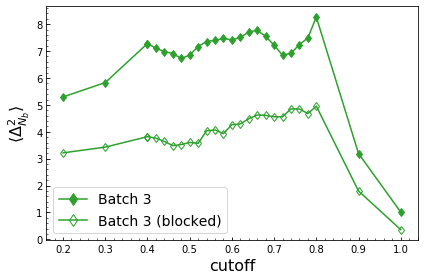

In [84]:
fig, ax = plt.subplots()
#ax.plot(cutoffs, delta_Nb0, marker='s', ls='-', label='Batch 1', color='C0')
#ax.plot(cutoffs, delta_Nb_blocked0, marker='s', ls='-', label='Batch 1 (blocked)', fillstyle='none', color='C0')
#ax.plot(cutoffs, delta_Nb1, marker='H', ls='-', label='Batch 2', color='C1')
#ax.plot(cutoffs, delta_Nb_blocked1, marker='H', ls='-', label='Batch 2 (blocked)', fillstyle='none', color='C1')
ax.plot(cutoffs, delta_Nb2, marker='d', ls='-', label='Batch 3', color='C2')
ax.plot(cutoffs, delta_Nb_blocked2, marker='d', ls='-', label='Batch 3 (blocked)', fillstyle='none', color='C2')
ax.set_xlabel(r"cutoff", fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$", fontsize=16)
ax.legend(loc='best', markerscale=1.5, fontsize=14)
fig.tight_layout()
fig.savefig('delta_Nb_vs_cutoff_with_blocked3.png', dpi=400, bbox_inches='tight')
plt.show()


### Blocked results

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle N_b\\rangle / V$')

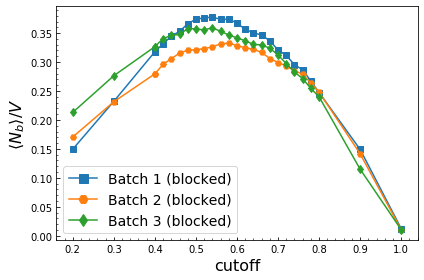

In [76]:
fig, ax = plt.subplots()
ax.plot(cutoffs, Nb_avg_blocked0, marker='s', ls='-', label='Batch 1 (blocked)')
ax.plot(cutoffs, Nb_avg_blocked1, marker='H', ls='-', label='Batch 2 (blocked)')
ax.plot(cutoffs, Nb_avg_blocked2, marker='d', ls='-', label='Batch 3 (blocked)')
ax.set_xlabel(r"cutoff", fontsize=16)
ax.set_ylabel(r"$\langle N_b\rangle / V$", fontsize=16)
ax.legend(loc='best', markerscale=1.5, fontsize=14)
fig.tight_layout()
fig.savefig('Nb_avg_vs_cutoff_blocked1.png', dpi=400, bbox_inches='tight')
plt.show()

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle$ (blocked once)')

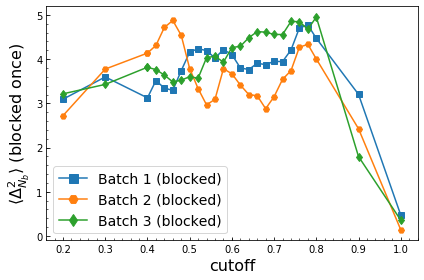

In [77]:
fig, ax = plt.subplots()
ax.plot(cutoffs, delta_Nb_blocked0, marker='s', ls='-', label='Batch 1 (blocked)')
ax.plot(cutoffs, delta_Nb_blocked1, marker='H', ls='-', label='Batch 2 (blocked)')
ax.plot(cutoffs, delta_Nb_blocked2, marker='d', ls='-', label='Batch 3 (blocked)')
ax.set_xlabel(r"cutoff", fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$ (blocked once)", fontsize=16)
ax.legend(loc='best', markerscale=1.5, fontsize=14)
fig.tight_layout()
fig.savefig('delta_Nb_vs_cutoff_blocked1.png', dpi=400, bbox_inches='tight')
plt.show()